In [1]:
import csv
import base64
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from io import BytesIO
from rdkit.Chem import Draw
from sklearn import manifold
import matplotlib.pyplot as plt
from scipy.spatial import distance
from rdkit.Chem import Descriptors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.preprocessing import StandardScaler
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.core.display import SVG, HTML

# Scaffolds

In [ ]:
def mol2display_png(mol):
    """Format RDKit mol for direct inline display. The most convenient, probably."""
    d2d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    buffer = BytesIO(d2d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [2]:
df = pd.read_csv('VEGF2.csv')
df = df.drop(['tid', 'standard_type', 'confidence_score', 'cmpd_pref_name', 'activity_comment'], axis=1)
df['mol'] = [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]

,cmpd_chembl_id,canonical_smiles,value,mol
0,CHEMBL356626,CCCOCc1ccc2c(c1)c3c4CNC(=O)c4c5c(Cc6ccccc56)c3...,7.890,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CHEMBL171558,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN5CCOCC5,6.600,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CHEMBL221053,CCc1cccc(NC(=O)Nc2ccc(cc2)c3cccc4[nH]nc(N)c34)c1,8.220,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CHEMBL3754450,COc1cccc(c1)C(=O)CN2CCN(CC2)c3nnc(c4ccccc4)c5c...,5.470,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CHEMBL383255,Cn1cnc(NCc2ccncc2)c1c3oc(Nc4ccc(OC(F)(F)F)cc4)nn3,7.105,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [4]:
drug = Chem.SDMolSupplier('drugbank.sdf')

In [5]:
ids=[]
for i in range(len(drug)):
    if drug[i] is not None:
        ids.append(drug[i].GetProp('DATABASE_ID')) 
inchi=[]
for i in range(len(drug)):
    if drug[i] is not None:
        inchi.append(drug[i].GetProp('INCHI_IDENTIFIER')) 

In [7]:
data = {'id': ids,
        'inchi': inchi}
drug_df = pd.DataFrame(data, columns = ['id', 'inchi'])
drug_df['mol'] = [Chem.inchi.MolFromInchi(i) for i in drug_df['inchi']]
drug_df = drug_df.dropna()

In [147]:
def mol2scaffold(mol):
    try: 
        scaffold1 = MurckoScaffold.GetScaffoldForMol(mol)
        scaffold2 = MurckoScaffold.MakeScaffoldGeneric(scaffold1)
        scaffold3 = MurckoScaffold.GetScaffoldForMol(scaffold2)
    except ValueError:
        return Chem.MolFromSmiles('*')
    return scaffold3

In [70]:
df["scaffold1"] = df['mol'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaffold2"] = df['scaffold1'].apply(MurckoScaffold.MakeScaffoldGeneric)
df["scaffold3"] = df['scaffold2'].apply(MurckoScaffold.GetScaffoldForMol)

In [79]:
df["scaffold3_smiles"] = df['scaffold3'].apply(Chem.MolToSmiles)

In [72]:
drug_df["scaffold1"] = drug_df['mol'].apply(MurckoScaffold.GetScaffoldForMol)
drug_df["scaffold2"] = drug_df['scaffold1'].apply(MurckoScaffold.MakeScaffoldGeneric)
drug_df["scaffold3"] = drug_df['scaffold2'].apply(MurckoScaffold.GetScaffoldForMol)

In [82]:
drug_df["scaffold3_smiles"] = drug_df['scaffold3'].apply(Chem.MolToSmiles)

C:\Users\domiz\Miniconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 5. Change the maxMols value to display more.
  warnings.warn(


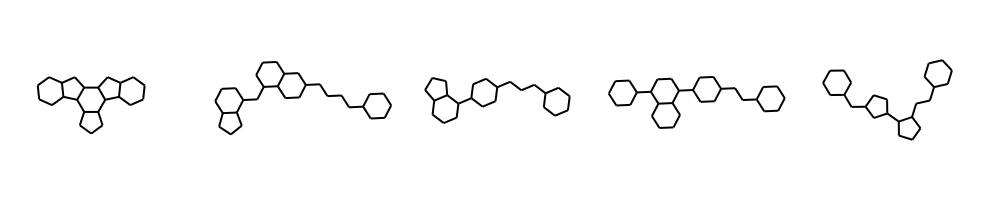

In [101]:
Draw.MolsToGridImage(df['scaffold3'], molsPerRow=5, maxMols=5)

,mol,scaffold3,canonical_smiles
0,,,CCCOCc1ccc2c(c1)c3c4CNC(=O)c4c5c(Cc6ccccc56)c3n2CCCO
1,,,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN5CCOCC5
2,,,CCc1cccc(NC(=O)Nc2ccc(cc2)c3cccc4[nH]nc(N)c34)c1
3,,,COc1cccc(c1)C(=O)CN2CCN(CC2)c3nnc(c4ccccc4)c5ccccc35
4,,,Cn1cnc(NCc2ccncc2)c1c3oc(Nc4ccc(OC(F)(F)F)cc4)nn3

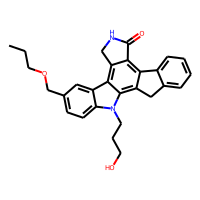
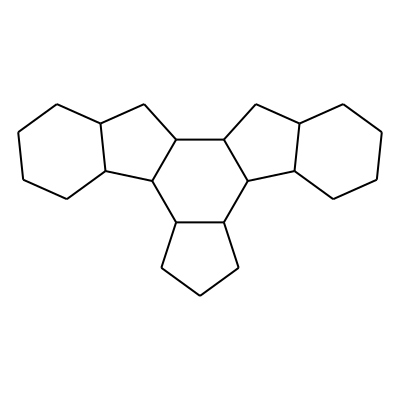
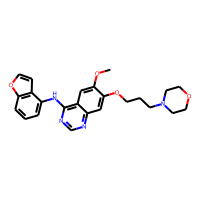
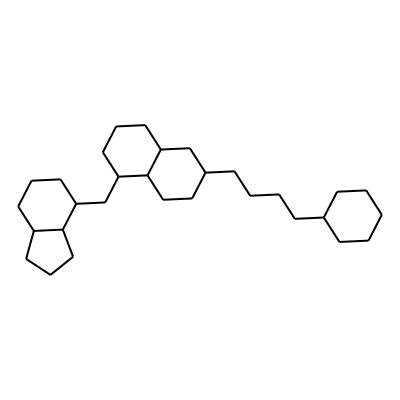
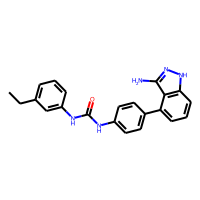
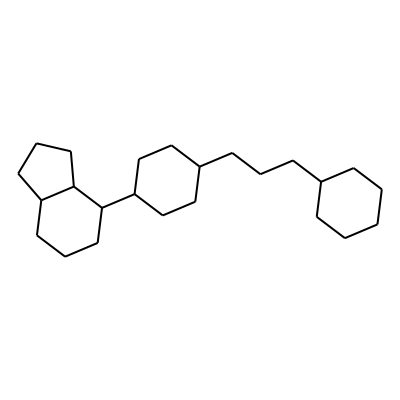
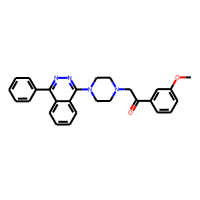
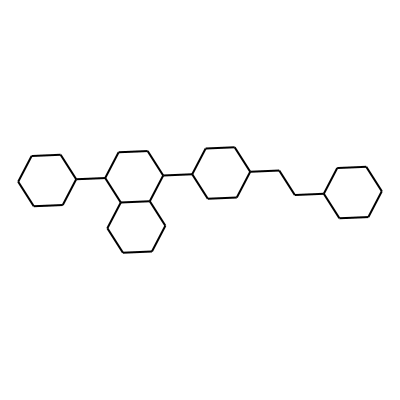
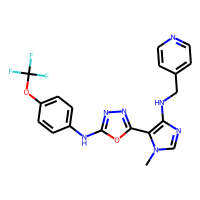
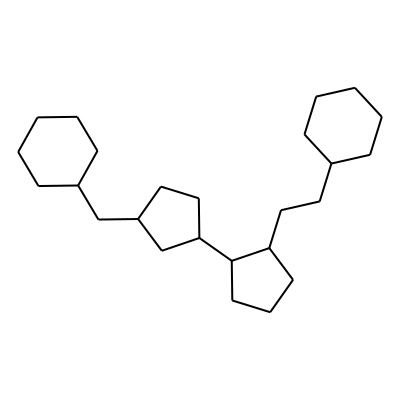

In [108]:
HTML(df[['mol','scaffold3','canonical_smiles']].head().to_html(formatters={'scaffold3': mol2display_png}, escape=False))

C:\Users\domiz\Miniconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 5. Change the maxMols value to display more.
  warnings.warn(


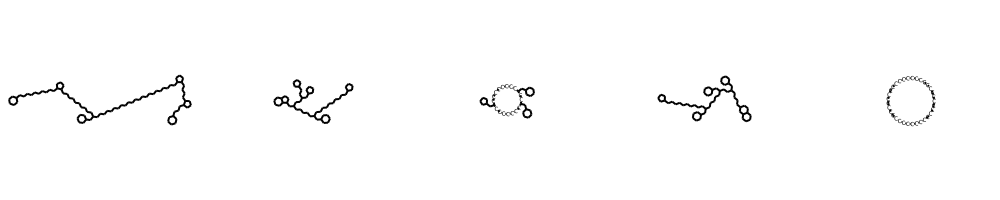

In [93]:
Draw.MolsToGridImage(drug_df['scaffold3'], molsPerRow=5, maxMols=5)

,mol,scaffold3
0,,
1,,
2,,
3,,
4,,

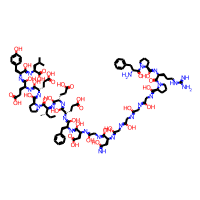
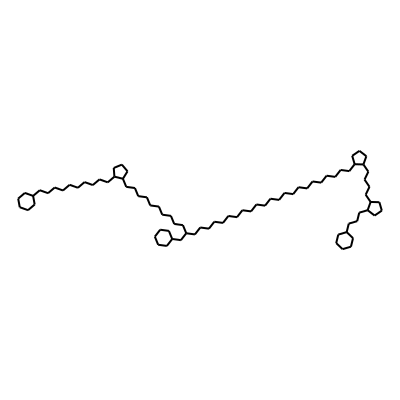
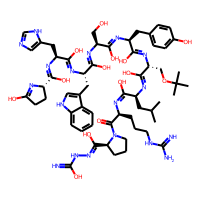
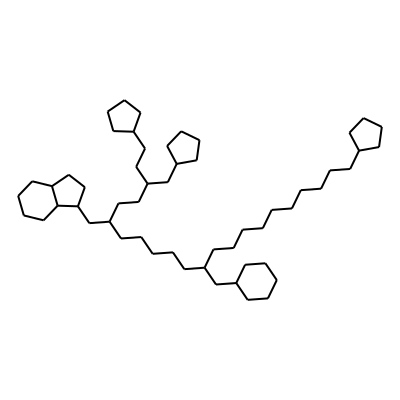
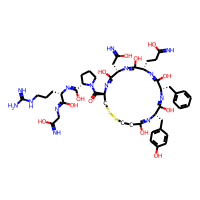
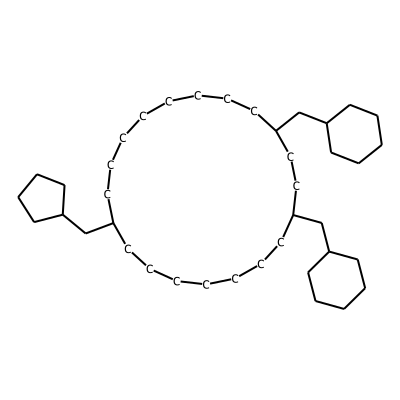
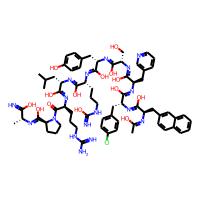
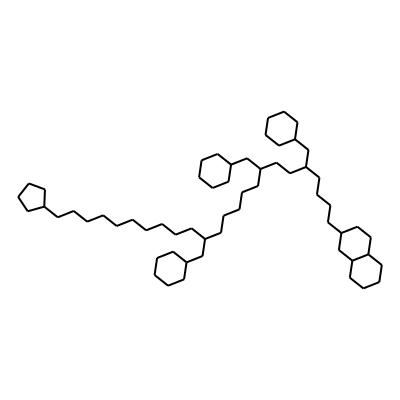
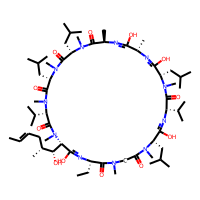
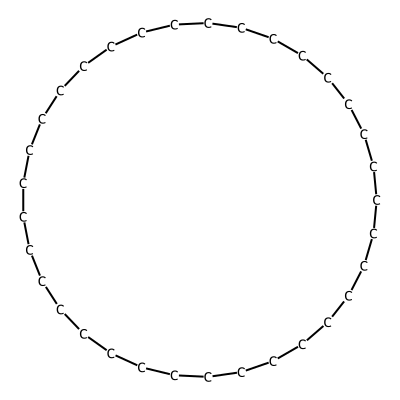

In [109]:
HTML(drug_df[['mol','scaffold3']].head().to_html(formatters={'scaffold3': mol2display_png}, escape=False))

# Nejcastejsi scaffoldy ve VEGF a drugBank

### *VEGF*

In [90]:
scaff_count = df['scaffold3_smiles'].value_counts()
scaff_count_df = pd.DataFrame(scaff_count)
scaff_count_df['scaffold'] = scaff_count_df.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

,scaffold3_smiles,scaffold
C1CCC(CC2CCCC3CCCCC32)CC1,328,
C1CCC(C2CCC3C(CCC3C3CCCCC3)C2)CC1,178,
C1CCC(CCCC2CCC(CC3CCCC(CCC4CC4)C3)CC2)CC1,157,
C1CCC(CCCC2CCC(C3CCCC4CCCC43)CC2)CC1,151,
C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,111,

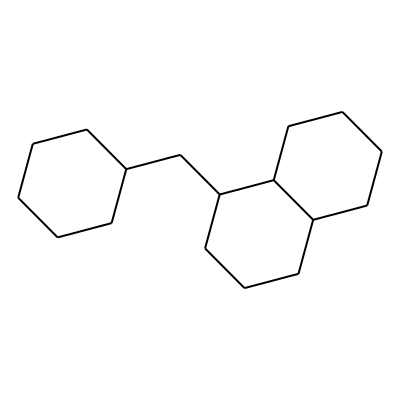
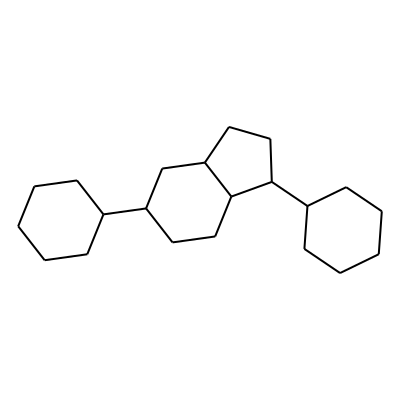
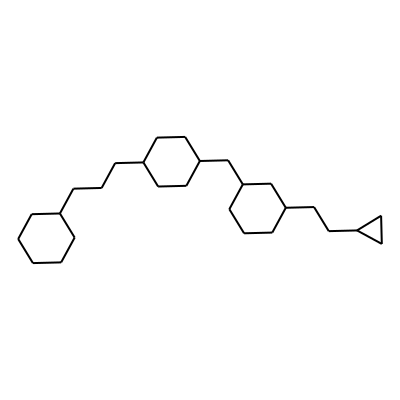
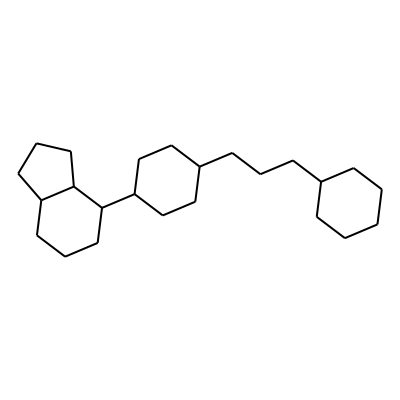
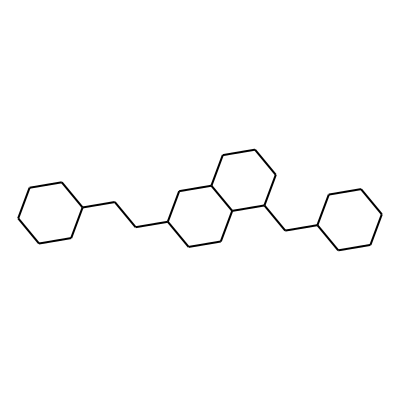

In [91]:
HTML(scaff_count_df.head().to_html(formatters={'scaffold': mol2display_png}, escape=False))

##### Jinak

In [17]:
VEGF_scaf_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(df['scaffold3']) if mol]
VEGF_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(df.mol) if mol]
VEGF_scaf_smiles[:5]

[(0, 'C1CCC2C(C1)CC1C3CC4CCCCC4C3C3CCCC3C21'),
 (1, 'C1CCC(CCCCC2CCC3C(CCCC3CC3CCCC4CCCC43)C2)CC1'),
 (2, 'C1CCC(CCCC2CCC(C3CCCC4CCCC43)CC2)CC1'),
 (3, 'C1CCC(CCC2CCC(C3CCC(C4CCCCC4)C4CCCCC34)CC2)CC1'),
 (4, 'C1CCC(CCC2CCCC2C2CCC(CC3CCCCC3)C2)CC1')]

In [18]:
scaffolds_VEGF = {scaffoldsmiles:[] for ligand_idx, scaffoldsmiles in VEGF_scaf_smiles}
for ligand_idx, scaffoldsmiles in VEGF_scaf_smiles:
    scaffolds_VEGF[scaffoldsmiles].append(ligand_idx)
#scaffolds2ligands

In [19]:
scaffold_count_VEGF = [(scaffold, len(ligands)) for scaffold, ligands in scaffolds_VEGF.items()]
scaffold_count_VEGF.sort(key=lambda x: x[1], reverse=True)
#len(scaffold_count_VEGF)
scaffold_count_VEGF[:10]

[('C1CCC(CC2CCCC3CCCCC32)CC1', 328),
 ('C1CCC(C2CCC3C(CCC3C3CCCCC3)C2)CC1', 178),
 ('C1CCC(CCCC2CCC(CC3CCCC(CCC4CC4)C3)CC2)CC1', 157),
 ('C1CCC(CCCC2CCC(C3CCCC4CCCC43)CC2)CC1', 151),
 ('C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1', 111),
 ('C1CCC(CCC2CCCC2CCC2CCCCC2)CC1', 89),
 ('C1CCC(C2CCC3CCCCC32)CC1', 89),
 ('C1CCC(CCCC2CCC(CC3CCCC(C4CCCC4)C3)CC2)CC1', 84),
 ('C1CCC(CCCC2CCC(C3CCC4CCCCC43)CC2)CC1', 79),
 ('C1CCC(CC2CCCCC2)CC1', 76)]

,mol,count
0,,328
1,,178
2,,157
3,,151
4,,111

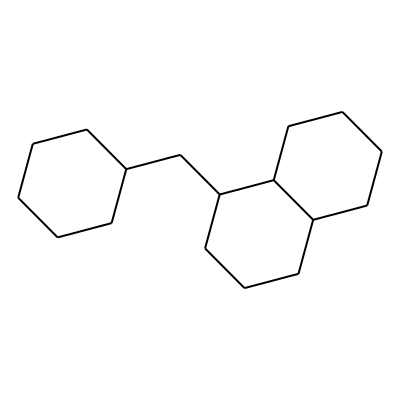
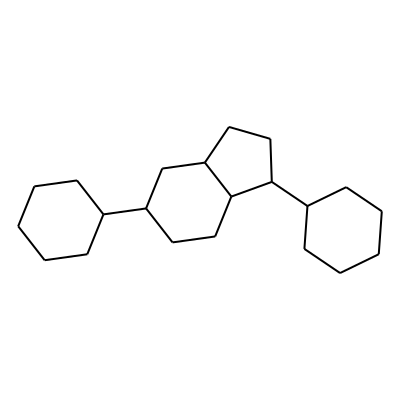
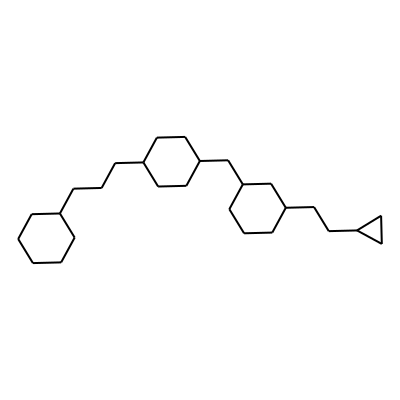
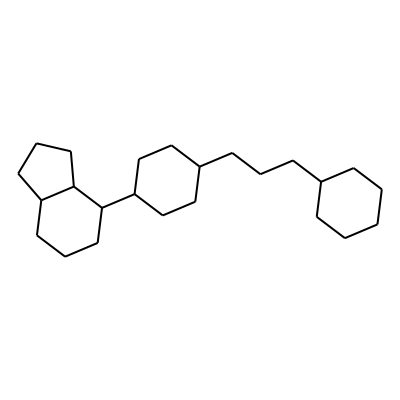
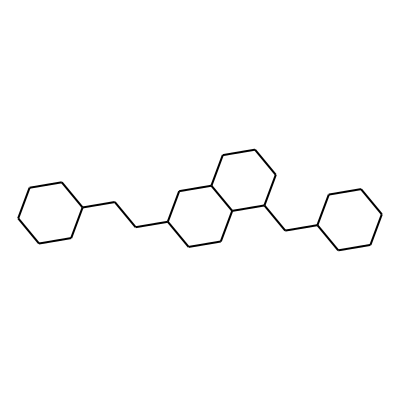

In [64]:
mols = [Chem.MolFromSmiles(scaffold_count_VEGF[i][0]) for i in range(len(scaffold_count_VEGF))]
count = [scaffold_count_VEGF[i][1] for i in range(len(scaffold_count_VEGF))]

ligands = pd.DataFrame(mols, columns=['mol'])
ligands['count'] = count
HTML(ligands.head().to_html(formatters={'mol': mol2display_png}, escape=False))

### *Drugbank*

In [94]:
scaff_count = drug_df['scaffold3_smiles'].value_counts()
scaff_count_df_drug = pd.DataFrame(scaff_count)
scaff_count_df_drug['scaffold'] = scaff_count_df.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

,scaffold3_smiles,scaffold
C1CCCCC1,1037,
,986,NaN
C1CCC2CCCC2C1,192,
C1CCCC1,187,NaN
C1CCC(CC2CCCCC2)CC1,182,

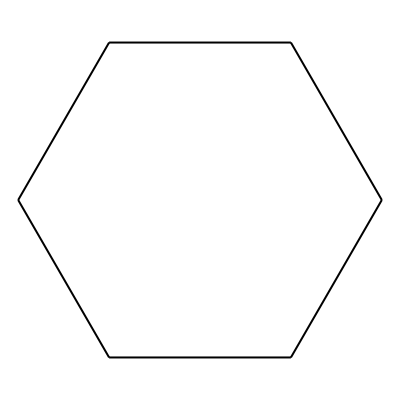
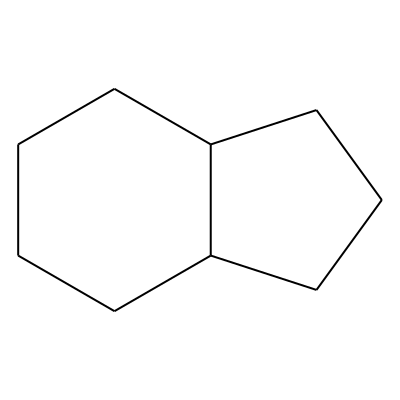
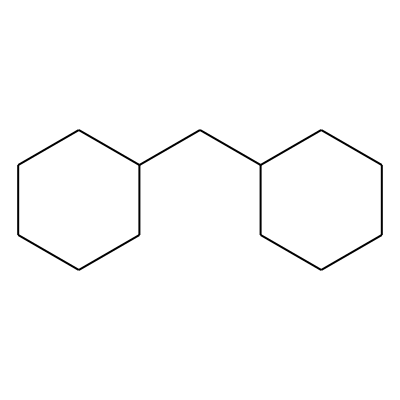

In [95]:
HTML(scaff_count_df_drug.head().to_html(formatters={'scaffold': mol2display_png}, escape=False))

#### Jinak

In [ ]:
drug_scaf_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(drug_df['scaffold3']) if mol]
drug_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(drug_df.mol) if mol]
drug_scaf_smiles[:5]

In [26]:
scaffolds_drug = {scaffoldsmiles:[] for ligand_idx, scaffoldsmiles in drug_scaf_smiles}
for ligand_idx, scaffoldsmiles in drug_scaf_smiles:
    scaffolds_drug[scaffoldsmiles].append(ligand_idx)
#scaffolds2ligands

In [27]:
scaffold_count_drug = [(scaffold, len(ligands)) for scaffold, ligands in scaffolds_drug.items()]
scaffold_count_drug.sort(key=lambda x: x[1], reverse=True)
#len(scaffold_ligandcount)
scaffold_count_drug[:10]

[('C1CCCCC1', 1037),
 ('', 986),
 ('C1CCC2CCCC2C1', 192),
 ('C1CCCC1', 187),
 ('C1CCC(CC2CCCCC2)CC1', 182),
 ('C1CCC(C2CCCC2)CC1', 177),
 ('C1CCC2C(C1)CCC2C1CCCC1', 167),
 ('C1CCC2CCCCC2C1', 167),
 ('C1CCC2C(C1)CCC1C3CCCC3CCC21', 151),
 ('C1CCC(CCC2CCCCC2)CC1', 106)]

,mol,count
0,,1037
1,,986
2,,192
3,,187
4,,182

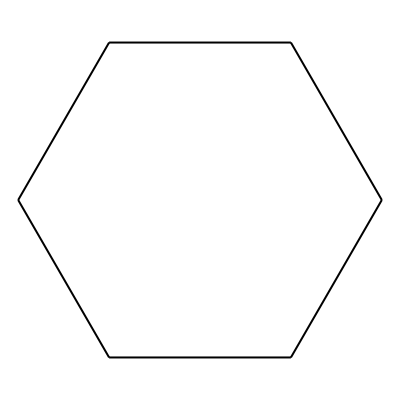
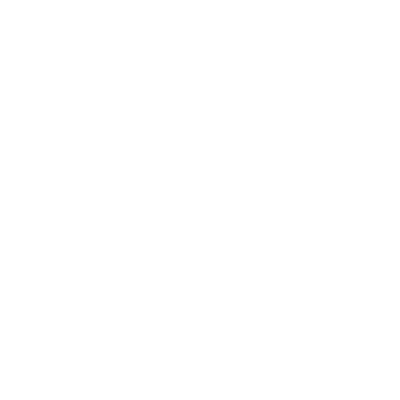
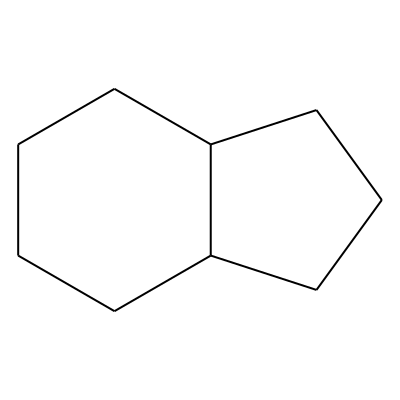
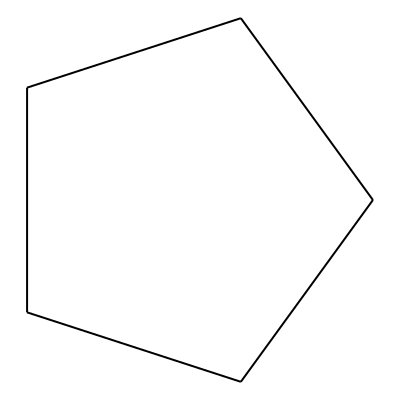
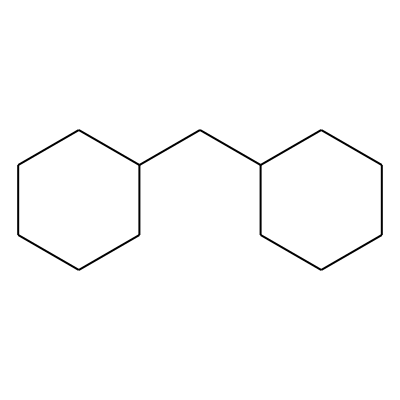

In [68]:
mols_drug = [Chem.MolFromSmiles(scaffold_count_drug[i][0]) for i in range(len(scaffold_count_drug))]
count_drug = [scaffold_count_drug[i][1] for i in range(len(scaffold_count_drug))]

drug_scaf = pd.DataFrame(mols_drug, columns=['mol'])
drug_scaf['count'] = count_drug
HTML(drug_scaf.head().to_html(formatters={'mol': mol2display_png}, escape=False))

In [106]:
df[:2]

,cmpd_chembl_id,canonical_smiles,value,mol,finger,scaffold1,scaffold2,scaffold3,scaffold,scaffold_smiles,scaffold3_smiles
0,CHEMBL356626,CCCOCc1ccc2c(c1)c3c4CNC(=O)c4c5c(Cc6ccccc56)c3...,7.89,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC2C(C1)CC1C3CC4CCCCC4C3C3CCCC3C21,C1CCC2C(C1)CC1C3CC4CCCCC4C3C3CCCC3C21
1,CHEMBL171558,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN5CCOCC5,6.60,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC(CCCCC2CCC3C(CCCC3CC3CCCC4CCCC43)C2)CC1,C1CCC(CCCCC2CCC3C(CCCC3CC3CCCC4CCCC43)C2)CC1


## Pravděpodobnost scaffoldů a jejich poměr

In [122]:
scaff_count_df["probability"] = scaff_count_df["scaffold3_smiles"].apply(lambda x: float(x)/len(df))
scaff_count_df.head()

,scaffold3_smiles,scaffold,probability
C1CCC(CC2CCCC3CCCCC32)CC1,328,"<img data-content=""rdkit/molecule"" src=""data:i...",0.048846
C1CCC(C2CCC3C(CCC3C3CCCCC3)C2)CC1,178,"<img data-content=""rdkit/molecule"" src=""data:i...",0.026508
C1CCC(CCCC2CCC(CC3CCCC(CCC4CC4)C3)CC2)CC1,157,"<img data-content=""rdkit/molecule"" src=""data:i...",0.023380
C1CCC(CCCC2CCC(C3CCCC4CCCC43)CC2)CC1,151,"<img data-content=""rdkit/molecule"" src=""data:i...",0.022487
C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,111,"<img data-content=""rdkit/molecule"" src=""data:i...",0.016530


In [124]:
scaff_count_df_drug["probability"] = scaff_count_df_drug["scaffold3_smiles"].apply(lambda x: float(x)/len(drug_df))
scaff_count_df_drug.head()

,scaffold3_smiles,scaffold,probability
C1CCCCC1,1037,"<img data-content=""rdkit/molecule"" src=""data:i...",0.145810
,986,NaN,0.138639
C1CCC2CCCC2C1,192,"<img data-content=""rdkit/molecule"" src=""data:i...",0.026997
C1CCCC1,187,NaN,0.026294
C1CCC(CC2CCCCC2)CC1,182,"<img data-content=""rdkit/molecule"" src=""data:i...",0.025591


In [141]:
scaffolds_merge = scaff_count_df.merge(scaff_count_df_drug, left_index=True, right_index=True)
scaffolds_merge["probabiliy diff"] = scaffolds_merge['probability_x'] / scaffolds_merge['probability_y'] 
scaffolds_merge.sort_values(by=['probabiliy diff'], ascending=False, inplace=True)

In [144]:
scaffolds_merge.head()

,scaffold3_smiles_x,scaffold_x,probability_x,scaffold3_smiles_y,scaffold_y,probability_y,probabiliy diff
C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,111,"<img data-content=""rdkit/molecule"" src=""data:i...",0.016530,2,"<img data-content=""rdkit/molecule"" src=""data:i...",0.000281,58.781236
C1CCC(CCC2CCCC(C3CCC4CCCCC4C3)C2)CC1,45,"<img data-content=""rdkit/molecule"" src=""data:i...",0.006701,1,"<img data-content=""rdkit/molecule"" src=""data:i...",0.000141,47.660462
C1CCC(CC2CCC(CC3CCCCC3)C3CCCCC23)CC1,34,"<img data-content=""rdkit/molecule"" src=""data:i...",0.005063,1,"<img data-content=""rdkit/molecule"" src=""data:i...",0.000141,36.010127
C1CCC(CC2CCCC(C3CCCC3C3CCCCC3)C2)CC1,30,"<img data-content=""rdkit/molecule"" src=""data:i...",0.004468,1,"<img data-content=""rdkit/molecule"" src=""data:i...",0.000141,31.773641
C1CCC(CCC2CCCC(CC3CCCCC3C3CCCCC3)C2)CC1,29,"<img data-content=""rdkit/molecule"" src=""data:i...",0.004319,1,"<img data-content=""rdkit/molecule"" src=""data:i...",0.000141,30.714520


Scaffoldy vyskytující se častěji ve VEGF datasetu

,scaffold_x,probabiliy diff
C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,,58.781236
C1CCC(CCC2CCCC(C3CCC4CCCCC4C3)C2)CC1,,47.660462
C1CCC(CC2CCC(CC3CCCCC3)C3CCCCC23)CC1,,36.010127
C1CCC(CC2CCCC(C3CCCC3C3CCCCC3)C2)CC1,,31.773641
C1CCC(CCC2CCCC(CC3CCCCC3C3CCCCC3)C2)CC1,,30.714520
C1CCC(C2CCCC2C2CCC3CCCCC32)CC1,,29.655398
C1CCC(CCC2CCCC2CCC2CCCCC2)CC1,,23.565450
C1CCC(CCCC2CCC(C3CCC4C(CCC4C4CCCCC4)C3)CC2)CC1,,18.005063
C1CCC(CCC2CCCC(CCC3CCCCC3)C2)CC1,,16.945942
C1CCC(CCCC2CCC3CCCCC3C2)C1,,16.945942

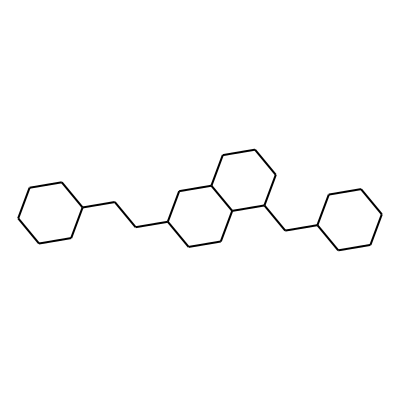
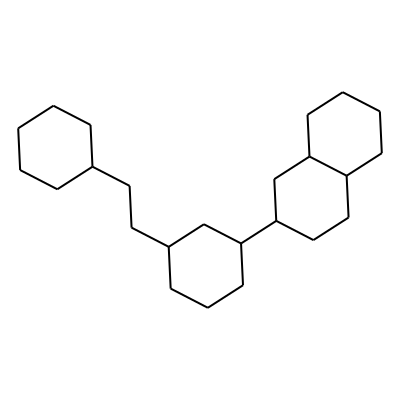
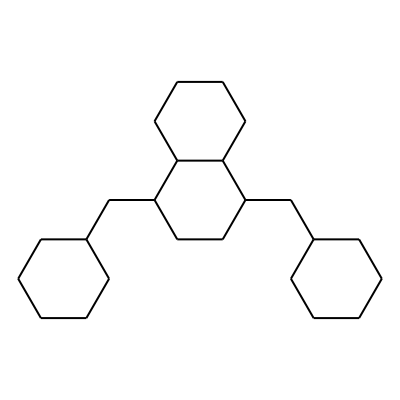
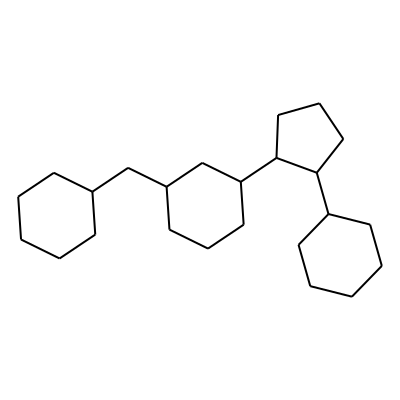
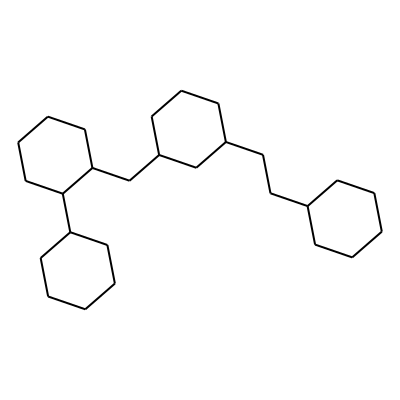
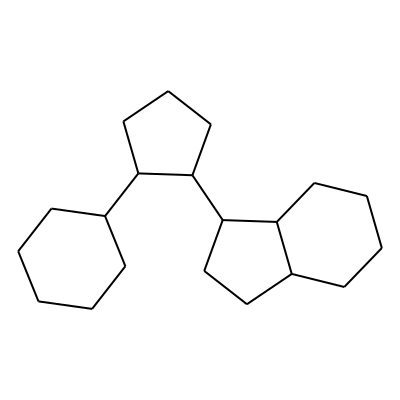
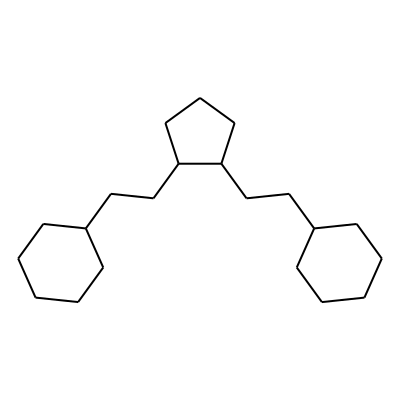
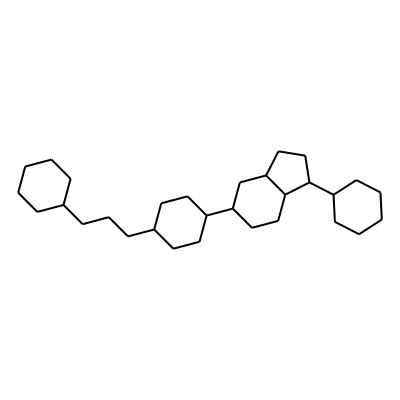
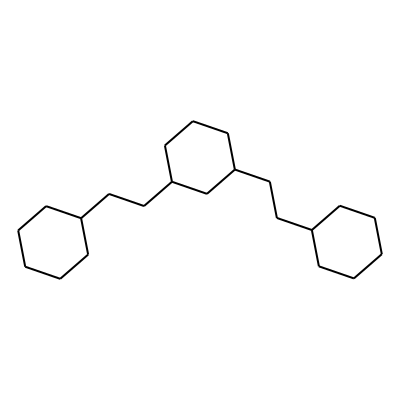
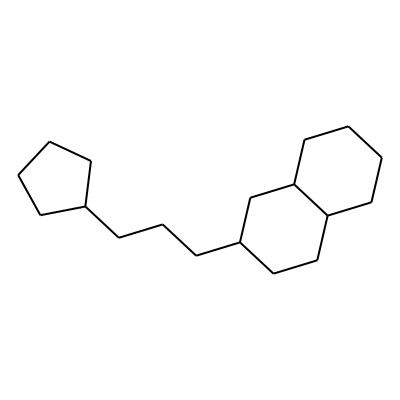

In [145]:
HTML(scaffolds_merge[['scaffold_x','probabiliy diff']].head(10).to_html(
    formatters={'scaffold_x': mol2display_png}, escape=False))

Scaffoldy vyskytující se častěji ve DrugBank

,scaffold_x,probabiliy diff
C1CCC(CC2CC3CCCCC3C2)CC1,,0.052956
C1CCC2CC3CCCCC3CC2C1,,0.035902
C1CCC(CCCC2CCCCC2)CC1,,0.032095
C1CCC(CCC2CCCC2)CC1,,0.024631
C1CCC2C(C1)CCC2C1CCCC1,,0.019026
C1CCC2CCCCC2C1,,0.019026
C1CCC(C2CCCC2)CC1,,0.017951
C1CCC2CCCC2C1,,0.016549
C1CCC(CCC2CCCCC2)CC1,,0.009992
C1CCCCC1,,0.003064

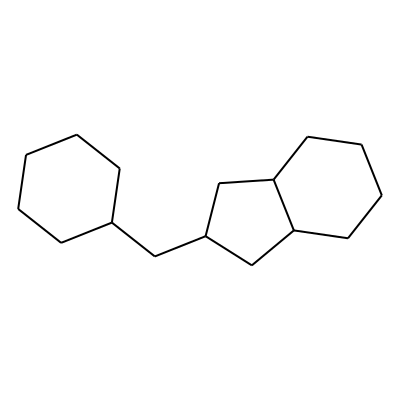
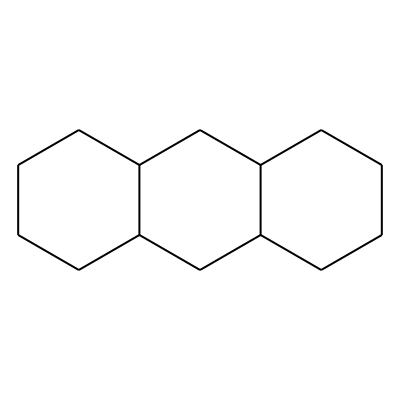
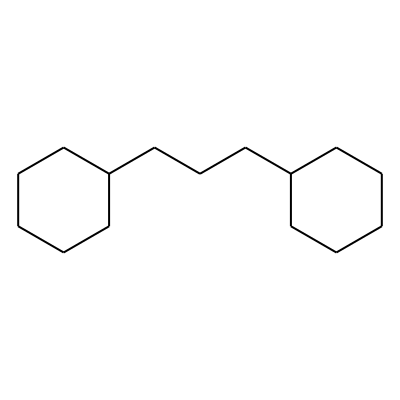
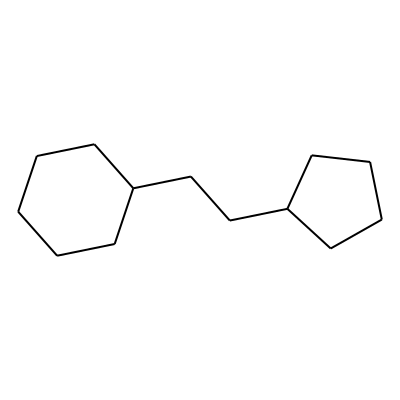
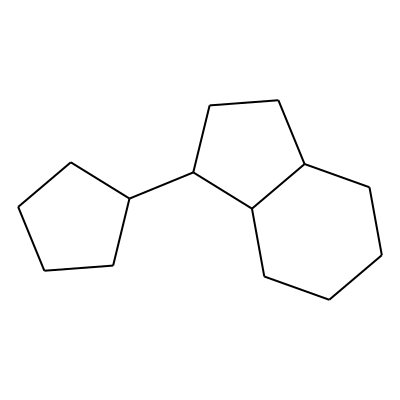
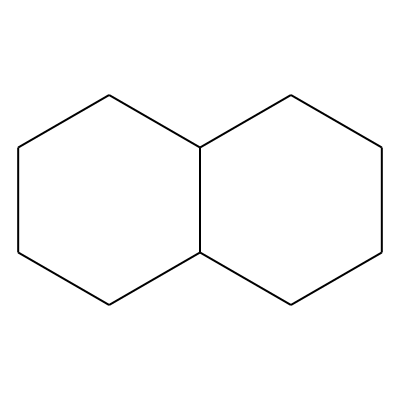
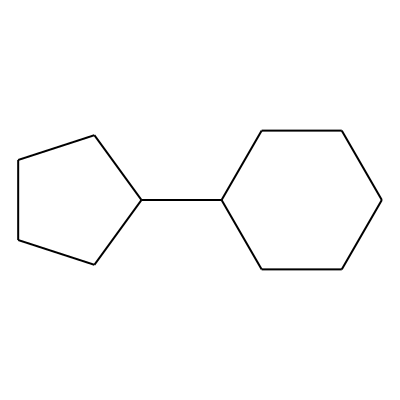
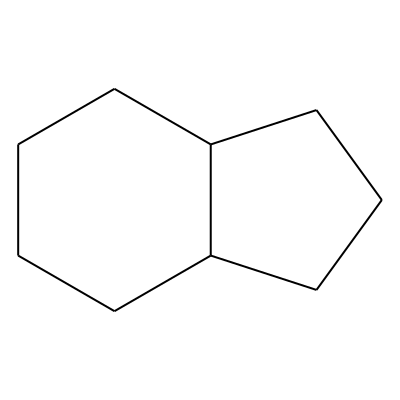
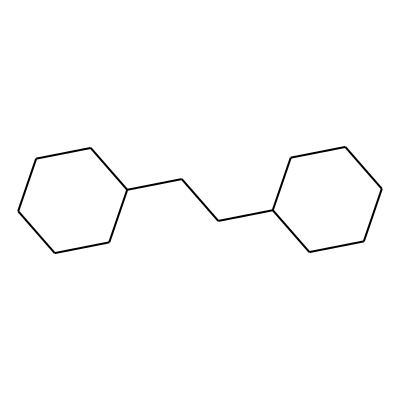
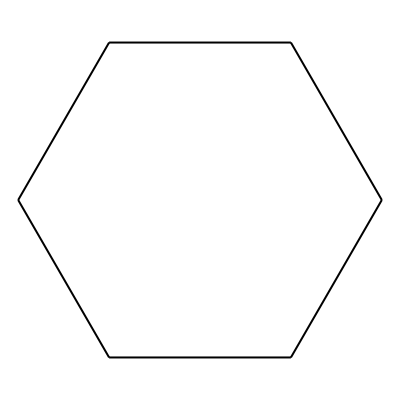

In [146]:
HTML(scaffolds_merge[['scaffold_x','probabiliy diff']].tail(10).to_html(
    formatters={'scaffold_x': mol2display_png}, escape=False))

In [152]:
#11?

In [157]:
df2 = df[['mol','scaffold3','scaffold3_smiles','value']]

In [158]:
df2.head()

,mol,scaffold3,scaffold3_smiles,value
0,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC2C(C1)CC1C3CC4CCCCC4C3C3CCCC3C21,7.890
1,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC(CCCCC2CCC3C(CCCC3CC3CCCC4CCCC43)C2)CC1,6.600
2,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC(CCCC2CCC(C3CCCC4CCCC43)CC2)CC1,8.220
3,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC(CCC2CCC(C3CCC(C4CCCCC4)C4CCCCC34)CC2)CC1,5.470
4,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC(CCC2CCCC2C2CCC(CC3CCCCC3)C2)CC1,7.105
